In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

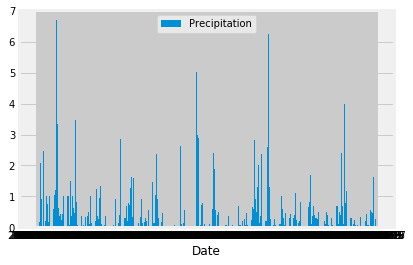

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc())
year_ago = (dt.date(int(latest_date[0][0][0:4]), int(latest_date[0][0][6]), int(latest_date[0][0][8:10])) - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
ltm_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(year_ago, latest_date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
ltm_prcp_df = pd.DataFrame(ltm_prcp, columns=['date', 'prcp']).set_index('date')

# Sort the dataframe by date
ltm_prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip = plt.bar(ltm_prcp_df.index, ltm_prcp_df['prcp'], label='Precipitation')
plt.grid(True)
plt.xlabel("Date")
plt.legend(handles=[precip], loc=9)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ltm_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset
session.query(func.count(Station.id)).all()

[(9)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter_by(station='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

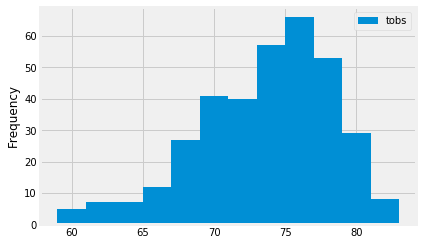

In [15]:
# Choose the station with the highest number of temperature observations
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_df = pd.DataFrame(session.query(Measurement.tobs).\
                       filter(Measurement.date.between(year_ago, latest_date)).\
                       filter_by(station='USC00519281').all())

tobs_df.plot.hist(bins=12)
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates
start_date = '2017-08-01'
end_date = '2017-08-14'
trip_temps = calc_temps(start_date, end_date)
print(trip_temps)

[(71.0, 79.01785714285714, 84.0)]


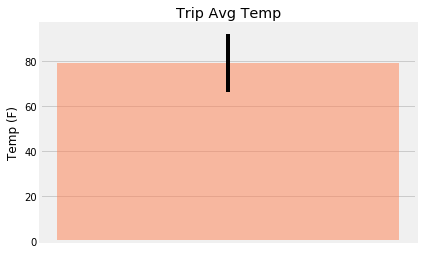

In [18]:
# Plot the results from your previous query as a bar chart
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_min = trip_temps[0][0]
trip_avg = trip_temps[0][1]
trip_max = trip_temps[0][2]

fig, ax = plt.subplots()
ax.bar(1, trip_avg, yerr=(trip_max-trip_min), color='coral', alpha=0.5)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

trip_prcp = session.query(*sel).filter(Station.station == Measurement.station).\
    filter(Measurement.date.between(start_date, end_date)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for record in trip_prcp:
    print(record)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.28)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.33)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.08)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017, 8, 1)
end_date = dt.date(2017, 8, 14)

# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
date_range = end_date - start_date
trip_dates = []
for i in range(date_range.days + 1):
    day = str(start_date + dt.timedelta(days=i))
    trip_dates.append(day)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_dates:
    normals.append(daily_normals(date[5:11])[0])

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax']).set_index([trip_dates])
normals_df.index.name = 'date'
normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0


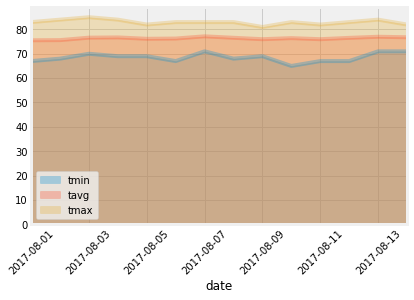

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=0.3, rot=45)
plt.show()